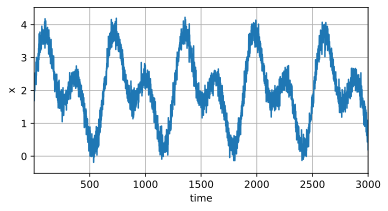

In [135]:
import torch
from torch import nn
from d2l import torch as d2l

T = 5000  # 总共产生1000个点
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time)+torch.normal(0,0.2,(T,))+2+torch.sin(0.01*2*time)
# 绘制时域图
d2l.plot(time, [x], 'time', 'x', xlim=[1, 3000], figsize=(6, 3))


In [149]:
tau = 60
features = torch.zeros((T - tau, tau))
for i in range(tau):
    features[:, i] = x[i: T - tau + i]
labels = x[tau:].reshape((-1, 1))

batch_size, n_train = 60, 240
# 只有前n_train个样本用于训练
train_iter = d2l.load_array((features[:n_train], labels[:n_train]),
                            batch_size, is_train=True)

In [150]:
# 初始化网络权重的函数
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

In [153]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            # 将时间序列数据转换到频域
            X_freq = torch.fft.rfft(X, dim=1)
            
            # 在频域中进行处理
            trainer.zero_grad()
            # 将频域数据输入网络
            output_freq = net(X_freq.abs())
            
            # 将输出转换回时域
            output = torch.fft.irfft(output_freq.unsqueeze(-1).to(torch.complex64), n=X.shape[1], dim=1)
            
            # 取output的最后一个时间点作为预测值
            output = output[:, -1].reshape(-1, 1)  # 形状变为[batch_size, 1]
            
            l = loss(output, y)
            l.sum().backward()
            trainer.step()
        print(f'epoch {epoch + 1}, '
              f'loss: {evaluate_freq_loss(net, train_iter, loss):f}')

# 创建一个专门用于频域模型的评估函数
def evaluate_freq_loss(net, data_iter, loss):
    """评估频域模型在给定数据集上的损失"""
    metric = d2l.Accumulator(2)  # 损失的总和, 样本数量
    with torch.no_grad():
        for X, y in data_iter:
            # 将输入转换到频域
            X_freq = torch.fft.rfft(X, dim=1)
            # 获取网络输出
            output_freq = net(X_freq.abs())
            # 转换回时域
            output = torch.fft.irfft(output_freq.unsqueeze(-1).to(torch.complex64), n=X.shape[1], dim=1)
            # 取最后一个时间点
            output = output[:, -1].reshape(-1, 1)
            l = loss(output, y)
            metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

# 修改网络以适应频域输入
def get_freq_net():
    # 输入维度为tau//2+1，这是rfft的输出大小
    net = nn.Sequential(nn.Linear(tau//2+1, 30),
                        nn.ReLU(),
                        nn.Linear(30, 15),
                        nn.ReLU(),
                        nn.Linear(15, tau//2+1))
    net.apply(init_weights)
    return net

net = get_freq_net()
train(net, train_iter, loss, 50, 0.05)

epoch 1, loss: 10.764632
epoch 2, loss: 0.695371
epoch 3, loss: 0.243798
epoch 4, loss: 0.379586
epoch 5, loss: 0.218938
epoch 6, loss: 0.225852
epoch 7, loss: 0.176452
epoch 8, loss: 0.165741
epoch 9, loss: 0.187598
epoch 10, loss: 0.274738
epoch 11, loss: 0.170497
epoch 12, loss: 0.171203
epoch 13, loss: 0.195326
epoch 14, loss: 0.169424
epoch 15, loss: 0.147646
epoch 16, loss: 0.144060
epoch 17, loss: 0.144986
epoch 18, loss: 0.148830
epoch 19, loss: 0.137684
epoch 20, loss: 0.133210
epoch 21, loss: 0.128853
epoch 22, loss: 0.125614
epoch 23, loss: 0.126500
epoch 24, loss: 0.118842
epoch 25, loss: 0.142454
epoch 26, loss: 0.115169
epoch 27, loss: 0.109845
epoch 28, loss: 0.125488
epoch 29, loss: 0.108697
epoch 30, loss: 0.106957
epoch 31, loss: 0.101530
epoch 32, loss: 0.096192
epoch 33, loss: 0.099157
epoch 34, loss: 0.114615
epoch 35, loss: 0.098520
epoch 36, loss: 0.090692
epoch 37, loss: 0.087914
epoch 38, loss: 0.084791
epoch 39, loss: 0.157744
epoch 40, loss: 0.081279
epoch 41

In [ ]:
# def train(net, train_iter, loss, epochs, lr):
#     trainer = torch.optim.Adam(net.parameters(), lr)
#     for epoch in range(epochs):
#         for X, y in train_iter:
#             trainer.zero_grad()
#             l = loss(net(X), y)
#             l.sum().backward()
#             trainer.step()
#         print(f'epoch {epoch + 1}, '
#               f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')

# net = get_net()
# train(net, train_iter, loss, 5, 0.01)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (60x60 and 4x10)

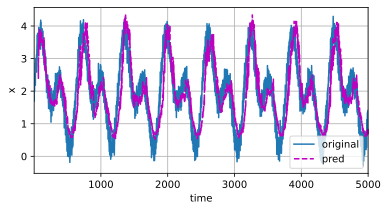

In [154]:
# 使用模型进行预测
import numpy as np
import matplotlib.pyplot as plt
with torch.no_grad():
    # 将输入转换到频域
    features_freq = torch.fft.rfft(features, dim=1)
    # 获取网络输出
    output_freq = net(features_freq.abs())
    # 转换回时域
    onestep_preds = torch.fft.irfft(output_freq.unsqueeze(-1).to(torch.complex64), n=features.shape[1], dim=1)

# 绘制时域预测图象和原始数据
d2l.plot([time, time[tau:]],
         [x.detach().numpy(), onestep_preds[:, -1].reshape(-1, 1).detach().numpy()], 'time',
         'x', legend=['original', 'pred'], xlim=[1, 5000],
         figsize=(6, 3))


<Figure size 1000x600 with 0 Axes>

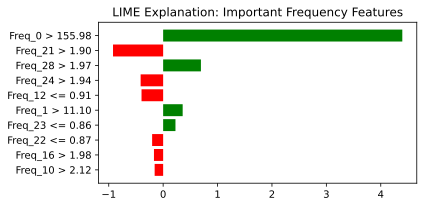

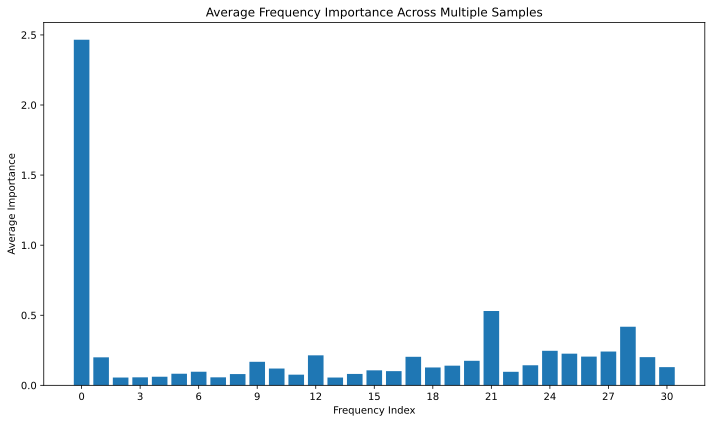

Top 5 most important frequencies:
Frequency 0: Importance = 2.4658
Frequency 21: Importance = 0.5305
Frequency 28: Importance = 0.4182
Frequency 24: Importance = 0.2463
Frequency 27: Importance = 0.2412


In [146]:
# 使用LIME解释模型预测中重要的频率
import lime
import lime.lime_tabular
import numpy as np
import matplotlib.pyplot as plt

# 准备数据用于LIME解释
# 将频域特征转换为numpy数组
features_freq_np = features_freq.abs().detach().numpy()

# 定义一个包装函数，使其与LIME兼容
def model_predict(data):
    # 将numpy数组转换回torch tensor
    data_tensor = torch.tensor(data, dtype=torch.float32)
    # 使用模型预测
    with torch.no_grad():
        return net(data_tensor).numpy()

# 创建LIME解释器
# 为频域特征创建特征名称
feature_names = [f'Freq_{i}' for i in range(features_freq_np.shape[1])]
explainer = lime.lime_tabular.LimeTabularExplainer(
    features_freq_np,
    feature_names=feature_names,
    class_names=[f'Output_{i}' for i in range(net(features_freq.abs()).shape[1])],
    mode='regression'
)

# 选择一个样本进行解释
sample_idx = 0  # 可以更改为任何有效的索引
exp = explainer.explain_instance(
    features_freq_np[sample_idx], 
    model_predict, 
    num_features=10  # 显示前10个最重要的特征
)

# 可视化LIME解释结果
plt.figure(figsize=(10, 6))
exp.as_pyplot_figure()
plt.title('LIME Explanation: Important Frequency Features')
plt.tight_layout()
plt.show()

# 分析多个样本以获得更稳定的解释
num_samples = min(500, len(features_freq_np))  # 分析前10个样本或所有样本
feature_importance = np.zeros(features_freq_np.shape[1])

for i in range(num_samples):
    exp = explainer.explain_instance(
        features_freq_np[i], 
        model_predict, 
        num_features=features_freq_np.shape[1]
    )
    # 累加特征重要性
    for feature, importance in exp.local_exp[0]:
        feature_importance[feature] += abs(importance)  # 使用绝对值，因为我们关心重要性大小

# 计算平均重要性
feature_importance /= num_samples

# 绘制频率重要性图
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importance)), feature_importance)
plt.xlabel('Frequency Index')
plt.ylabel('Average Importance')
plt.title('Average Frequency Importance Across Multiple Samples')
plt.xticks(range(0, len(feature_importance), max(1, len(feature_importance)//10)))
plt.tight_layout()
plt.show()

# 打印最重要的前5个频率
top_indices = np.argsort(feature_importance)[::-1][:5]
print("Top 5 most important frequencies:")
for idx in top_indices:
    print(f"Frequency {idx}: Importance = {feature_importance[idx]:.4f}")
